In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import numpy as np
import albumentations as A
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import scipy.ndimage as nd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# Stap 1: Dataset laden
def load_dataset(dataset_dir):
    X, y = [], []
    label_map = {str(i): i for i in range(10)}
    
    for label_str in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_str)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            img_path = os.path.join(label_path, fname)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            X.append(img_to_array(img) / 255.0)
            y.append(label_map[label_str])
    
    return np.array(X), np.array(y)

X, y = load_dataset("synthetic_digits/train")
X, y = shuffle(X, y, random_state=2003)

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Augmentaties definiëren

In [7]:
def voeg_rafelruis_toe(img, ruis_std=0.02, drempel=0.6):
    if img.max() > 1.0:
        img = img / 255.0

    if img.ndim == 3:
        img = img.mean(axis=-1)

    binair = (img > drempel).astype(np.float32)

    # Subtiele rand met Sobel
    dx = nd.sobel(binair, axis=0)
    dy = nd.sobel(binair, axis=1)
    rand = np.hypot(dx, dy)

    # Jitter op kleine subset van rand
    jitter = np.random.normal(loc=0.0, scale=ruis_std, size=img.shape)
    jitter = gaussian_filter(jitter, sigma=0.3)
    masker = (rand > 0.1) & (np.random.rand(*img.shape) < 0.3)
    img = img + (jitter * masker)

    img = np.clip(img, 0.0, 1.0)
    binair = (img > drempel).astype(np.float32)

    return np.expand_dims(binair, axis=-1)


In [8]:
# Stap 3: Albumentations augmentatie
albumentations_transform = A.Compose([
    A.LongestMaxSize(128),
    # Vervanging voor ImageDataGenerator augmentaties:
    A.Rotate(limit=5),
    A.Affine(scale=(0.85, 1.15)),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0),

    # Eerder gewenste vervormingen:
    A.OneOf([
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=1),
        A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)
    ], p=0.5),

    A.Resize(64, 64)
])


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\lenka\AppData\Local\Temp\ipykernel_11188\3089158211.py:13: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)


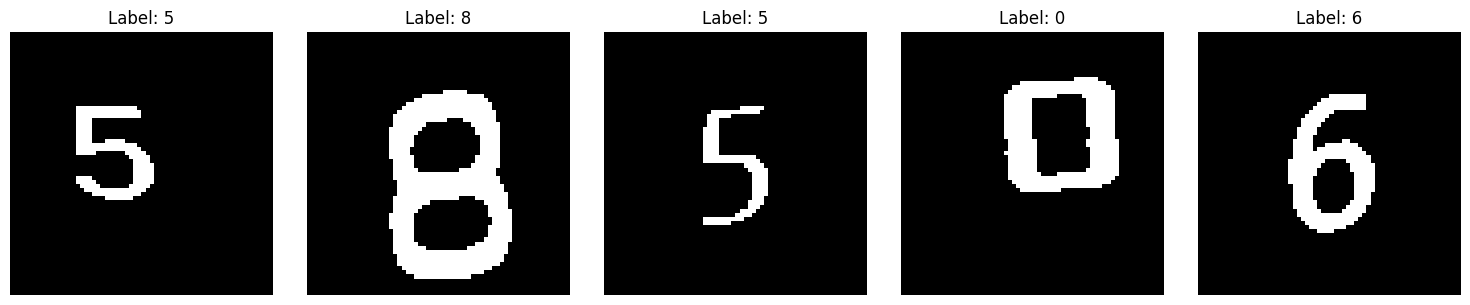

In [ ]:
batch_size = 5

gen = HybridAugmentGenerator(
        X, y,
        batch_size=32,
        albumentations_transform=albumentations_transform,
        keras_preprocessing_func=voeg_rafelruis_toe,
        shuffle=True
    )

images, labels = gen[0]

# Visualiseer de gegenereerde beelden
plt.figure(figsize=(15, 3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Trainen CNN (iteratie 2: extra laag)
Het CNN wordt getraind met een extra laag en K-fol cross validation

In [ ]:
# Stap 4: Hybride generator
class HybridAugmentGenerator(Sequence):
    def __init__(self, X, y, batch_size, albumentations_transform=None, keras_preprocessing_func=None, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.albu_transform = albumentations_transform
        self.keras_pre_func = keras_preprocessing_func
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        X_aug = []

        for img in X_batch:
            if self.albu_transform:
                img = self.albu_transform(image=img.astype(np.float32))['image']
            if self.keras_pre_func:
                img = self.keras_pre_func(img)
            X_aug.append(img)

        return np.stack(X_aug), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Stap 5: CNN model
def create_cnn_model(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
# Opslagmappen aanmaken (per fold)
os.makedirs("models", exist_ok=True)
os.makedirs("misclassificaties", exist_ok=True)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=2003)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

histories = []
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\n Fold {fold}")

    # Data splitsen
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Model initialiseren
    model = create_cnn_model()

    # Augmentatiegenerator voor training
    train_generator = HybridAugmentGenerator(
        X_train, y_train,
        batch_size=32,
        albumentations_transform=albumentations_transform,
        keras_preprocessing_func=voeg_rafelruis_toe,
        shuffle=True
    )

    # Eénmalige augmentatie op validatieset
    X_val_aug = []
    for img in X_val:
        if albumentations_transform:
            img = albumentations_transform(image=img.astype(np.float32))['image']
        if voeg_rafelruis_toe:
            img = voeg_rafelruis_toe(img)
        X_val_aug.append(img)
    X_val_aug = np.stack(X_val_aug)

    # Validatiegenerator zonder verdere augmentatie
    val_generator = HybridAugmentGenerator(
        X_val_aug, y_val,
        batch_size=32,
        albumentations_transform=None,
        keras_preprocessing_func=None,
        shuffle=False
    )

    # Model checkpoint
    checkpoint_path = f"models/best_model_fold{fold}.keras"
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False
    )

    # Model trainen
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=200,
        callbacks=[early_stop, checkpoint_cb],
        verbose=1
    )
    histories.append(history)

    # Beste model laden
    best_model = load_model(checkpoint_path)

    # Voorspellingen op validatieset
    y_pred_probs = best_model.predict(X_val_aug)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val

    # Confusion matrix genereren
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}')

    # Opslagpad voor resultaten
    output_dir = Path(f"misclassificaties/fold{fold}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Confusion matrix opslaan als afbeelding
    cm_path = output_dir / "confusion_matrix.png"
    plt.savefig(cm_path)
    plt.close()

    # Misclassificaties opslaan
    print(f"Misclassificaties opslaan voor Fold {fold}")
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred:
            img = X_val_aug[i]
            if img.dtype != np.uint8:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)

            if img.ndim == 2:
                pil_img = Image.fromarray(img, mode="L")
            elif img.shape[2] == 1:
                pil_img = Image.fromarray(img.squeeze(), mode="L")
            else:
                pil_img = Image.fromarray(img)

            filename = f"true_{true}_pred_{pred}_idx_{i}.png"
            pil_img.save(output_dir / filename)

    fold += 1



 Fold 1
Epoch 1/200


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.1462 - loss: 2.2564 - val_accuracy: 0.2416 - val_loss: 2.0622
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2930 - loss: 1.9511 - val_accuracy: 0.5843 - val_loss: 1.3864
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5648 - loss: 1.3996 - val_accuracy: 0.7416 - val_loss: 0.9021
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6852 - loss: 1.0408 - val_accuracy: 0.7865 - val_loss: 0.6963
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7633 - loss: 0.7681 - val_accuracy: 0.8258 - val_loss: 0.5809
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7902 - loss: 0.6290 - val_accuracy: 0.8764 - val_loss: 0.4976
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8481 - loss: 0.4940 - val_accuracy: 0.9045 - val_loss: 0.3675
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8608 - loss: 0.4567 - val_accuracy: 0.8933 - va

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.0968 - loss: 2.3016 - val_accuracy: 0.1910 - val_loss: 2.1755
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.3380 - loss: 2.0198 - val_accuracy: 0.4944 - val_loss: 1.5058
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4957 - loss: 1.4977 - val_accuracy: 0.7303 - val_loss: 0.9426
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.6704 - loss: 1.0649 - val_accuracy: 0.7921 - val_loss: 0.7046
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7705 - loss: 0.8172 - val_accuracy: 0.8539 - val_loss: 0.5388
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7846 - loss: 0.7173 - val_accuracy: 0.8764 - val_loss: 0.4170
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8303 - loss: 0.6131 - val_accuracy: 0.8876 - val_loss: 0.3387
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8088 - loss: 0.5994 - val_accuracy: 0.9101 - val_l

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.1635 - loss: 2.2768 - val_accuracy: 0.3090 - val_loss: 2.0293
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.3885 - loss: 1.9026 - val_accuracy: 0.5787 - val_loss: 1.4223
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5282 - loss: 1.4813 - val_accuracy: 0.7247 - val_loss: 0.9593
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7320 - loss: 0.9054 - val_accuracy: 0.8258 - val_loss: 0.6716
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7468 - loss: 0.8152 - val_accuracy: 0.8708 - val_loss: 0.5236
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7539 - loss: 0.7507 - val_accuracy: 0.8652 - val_loss: 0.5016
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7801 - loss: 0.6868 - val_accuracy: 0.9101 - val_loss: 0.3401
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8447 - loss: 0.4781 - val_accuracy: 0.9101 - val_

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.1230 - loss: 2.2816 - val_accuracy: 0.3596 - val_loss: 2.0622
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4086 - loss: 1.8804 - val_accuracy: 0.5000 - val_loss: 1.5935
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5796 - loss: 1.4079 - val_accuracy: 0.6517 - val_loss: 1.1170
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7035 - loss: 1.0704 - val_accuracy: 0.7191 - val_loss: 0.9092
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7215 - loss: 0.9160 - val_accuracy: 0.7640 - val_loss: 0.7276
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7959 - loss: 0.6905 - val_accuracy: 0.7865 - val_loss: 0.6310
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7682 - loss: 0.6685 - val_accuracy: 0.8483 - val_loss: 0.4393
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7911 - loss: 0.6104 - val_accuracy: 0.8764 - val_

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.1504 - loss: 2.2843 - val_accuracy: 0.2472 - val_loss: 2.1647
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.2964 - loss: 1.9896 - val_accuracy: 0.4944 - val_loss: 1.5509
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6133 - loss: 1.3546 - val_accuracy: 0.6404 - val_loss: 1.1396
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6837 - loss: 1.1086 - val_accuracy: 0.7865 - val_loss: 0.7601
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7327 - loss: 0.7990 - val_accuracy: 0.8315 - val_loss: 0.5960
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8235 - loss: 0.5938 - val_accuracy: 0.8539 - val_loss: 0.4424
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8195 - loss: 0.5570 - val_accuracy: 0.8933 - val_loss: 0.3433
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8374 - loss: 0.5354 - val_accuracy: 0.9213 - val_

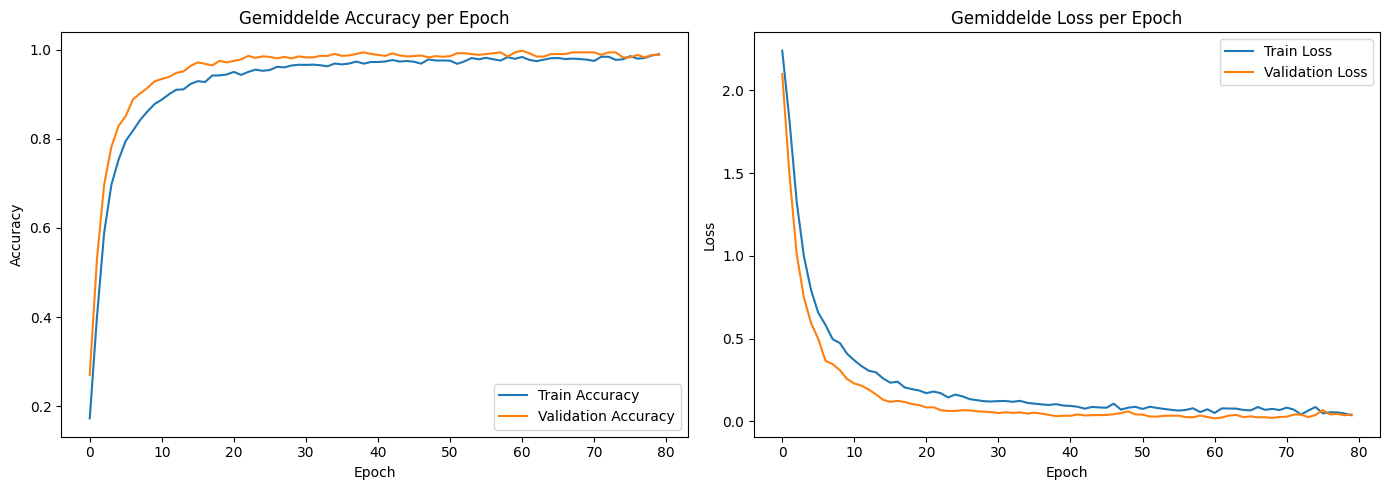

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_history(histories):
    max_epochs = max(len(h.history['accuracy']) for h in histories)

    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []

    for h in histories:
        num_epochs = len(h.history['accuracy'])

        # Vul aan tot max_epochs met NaN
        train_acc = np.array(h.history['accuracy'] + [np.nan] * (max_epochs - num_epochs))
        val_acc = np.array(h.history['val_accuracy'] + [np.nan] * (max_epochs - num_epochs))
        train_loss = np.array(h.history['loss'] + [np.nan] * (max_epochs - num_epochs))
        val_loss = np.array(h.history['val_loss'] + [np.nan] * (max_epochs - num_epochs))

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)

    avg_train_acc = np.nanmean(all_train_acc, axis=0)
    avg_val_acc = np.nanmean(all_val_acc, axis=0)
    avg_train_loss = np.nanmean(all_train_loss, axis=0)
    avg_val_loss = np.nanmean(all_val_loss, axis=0)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Train Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title("Gemiddelde Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Train Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title("Gemiddelde Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_avg_history(histories)


In [16]:
for i, h in enumerate(histories, 1):
    best_val_acc = max(h.history['val_accuracy']) if 'val_accuracy' in h.history else None
    print(f"Fold {i}: beste validation accuracy = {best_val_acc:.4f}")


Fold 1: beste validation accuracy = 1.0000
Fold 2: beste validation accuracy = 1.0000
Fold 3: beste validation accuracy = 1.0000
Fold 4: beste validation accuracy = 1.0000
Fold 5: beste validation accuracy = 1.0000


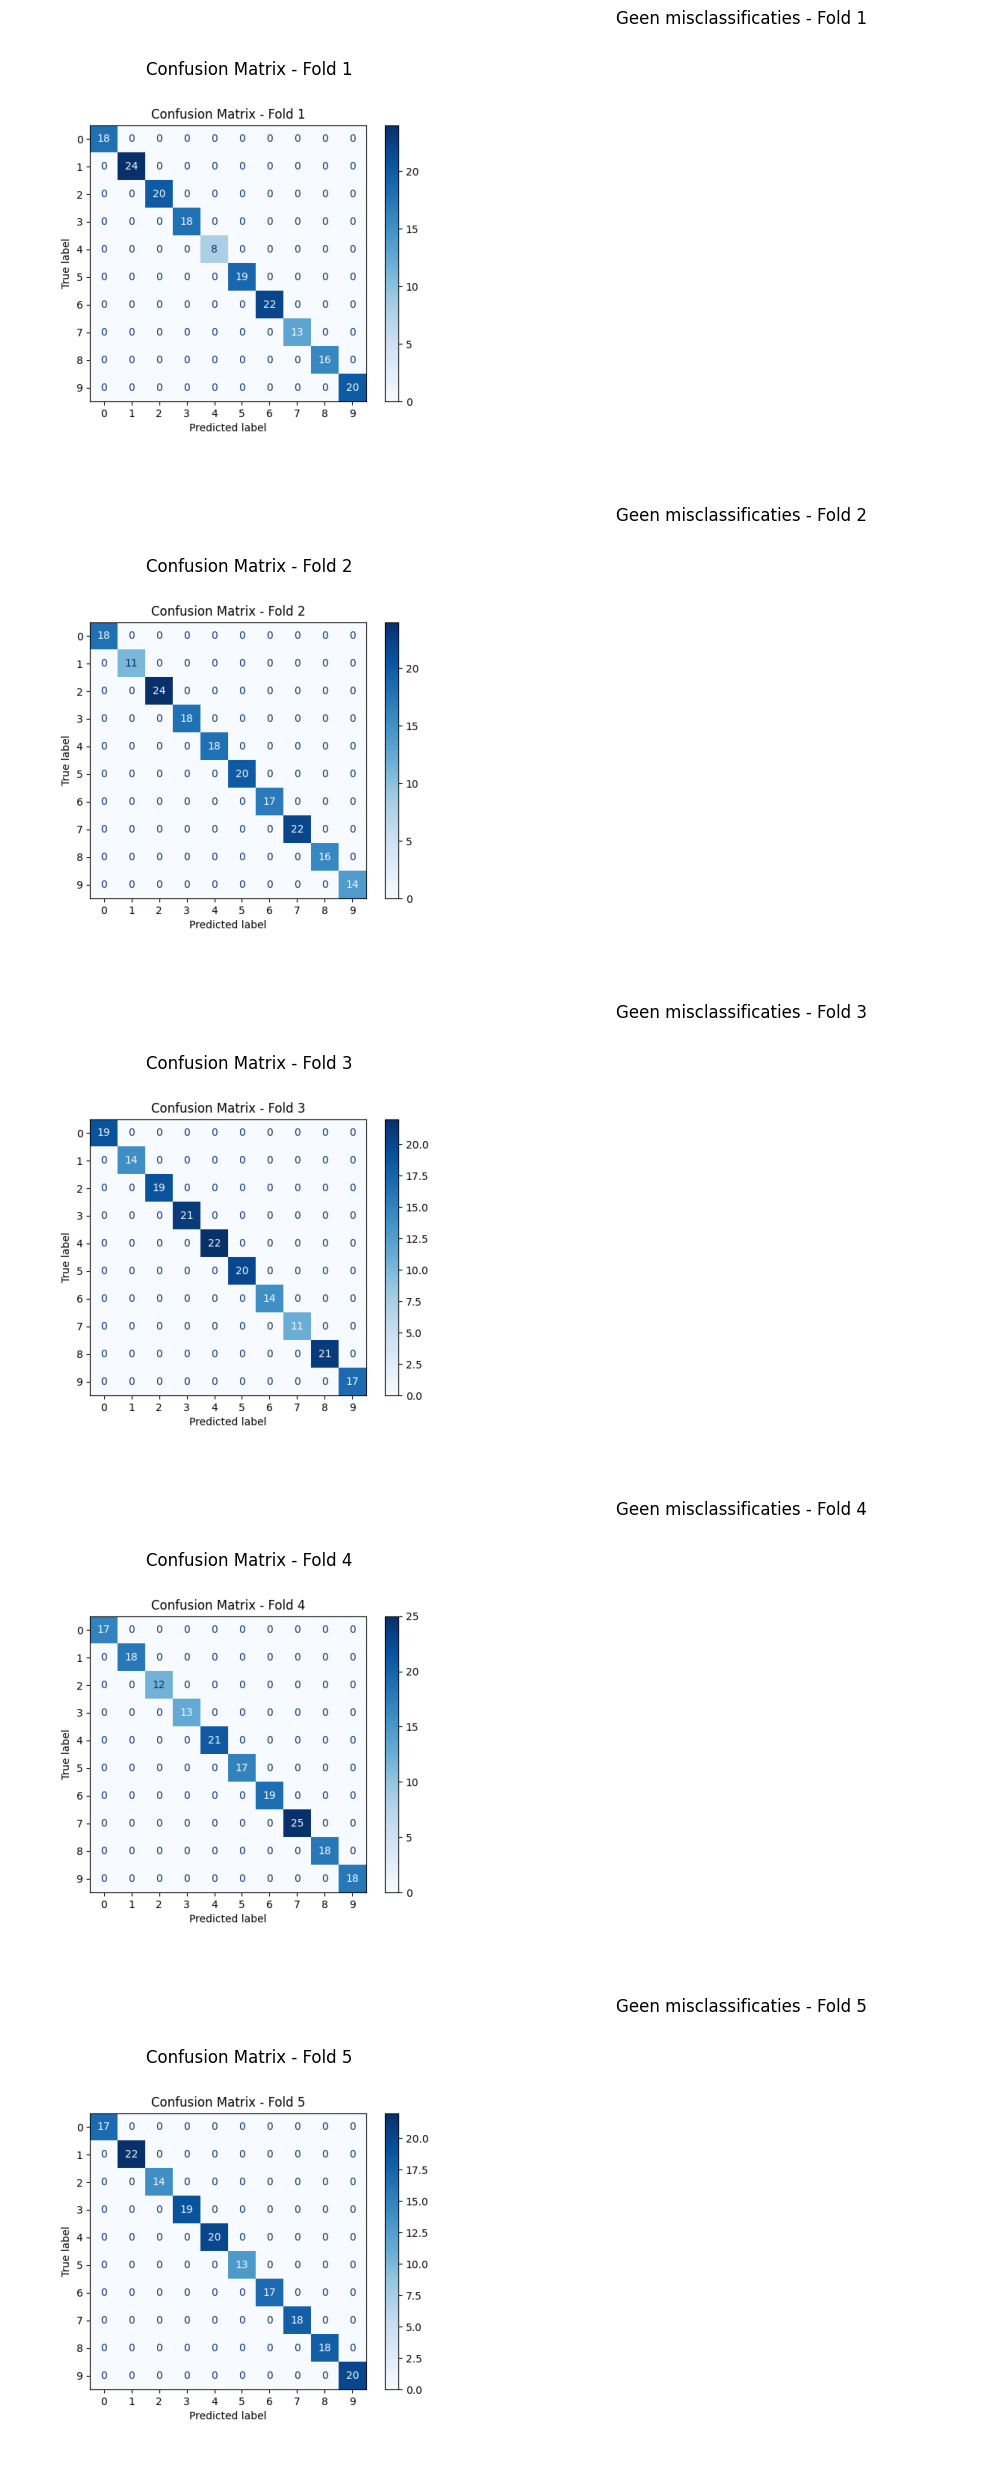

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Aantal folds
num_folds = 5

# Layout: 2 kolommen per fold (confusion matrix + misclassificatie)
fig, axes = plt.subplots(num_folds, 2, figsize=(10, 5 * num_folds))

for i in range(num_folds):
    fold_num = i + 1
    fold_dir = Path(f"misclassificaties/fold{fold_num}")
    
    # Confusion matrix laden
    cm_path = fold_dir / "confusion_matrix.png"
    if cm_path.exists():
        cm_img = Image.open(cm_path)
        axes[i, 0].imshow(cm_img)
        axes[i, 0].set_title(f'Confusion Matrix - Fold {fold_num}')
    else:
        axes[i, 0].set_title(f'CM niet gevonden - Fold {fold_num}')
    axes[i, 0].axis('off')

    # Misclassificatie-afbeeldingen zoeken
    misclassified_imgs = list(fold_dir.glob("true_*_pred_*_idx_*.png"))
    
    if len(misclassified_imgs) == 1:
        img = Image.open(misclassified_imgs[0])
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(f'Misclassificatie - Fold {fold_num}')
    elif len(misclassified_imgs) == 0:
        axes[i, 1].set_title(f'Geen misclassificaties - Fold {fold_num}')
    else:
        axes[i, 1].set_title(f'{len(misclassified_imgs)} misclassificaties - Fold {fold_num}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Trainen volledige dataset

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Opslagmap aanmaken
os.makedirs("models", exist_ok=True)

# Augmentatiegenerator voor training
train_generator = HybridAugmentGenerator(
    X, y,
    batch_size=32,
    albumentations_transform=albumentations_transform,
    keras_preprocessing_func=voeg_rafelruis_toe,
    shuffle=True
)

# Model initialiseren
model = create_cnn_model()

# Model checkpoint
checkpoint_path = "models/final_model_full_train.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',           # monitor een training-metric
    mode='max',                   # 'max' voor accuracy, 'min' voor loss
    save_best_only=True,
    save_weights_only=False
)


# Model trainen op volledige data
history = model.fit(
    train_generator,
    epochs=80,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Optioneel: model laden (bv. voor latere evaluatie of gebruik)
final_model = load_model(checkpoint_path)


Epoch 1/80


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.1159 - loss: 2.2785
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4208 - loss: 1.8207
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6053 - loss: 1.2660
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7327 - loss: 0.8642
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8073 - loss: 0.6075
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8134 - loss: 0.5315
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8398 - loss: 0.5194
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8395 - loss: 0.5049
Epoch 9/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8733 - loss: 0.3800
Epoch 10/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9120 - loss: 0.2896
Epoch 11/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9051 - loss: 0.2714
Epoch 12/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9083 - 

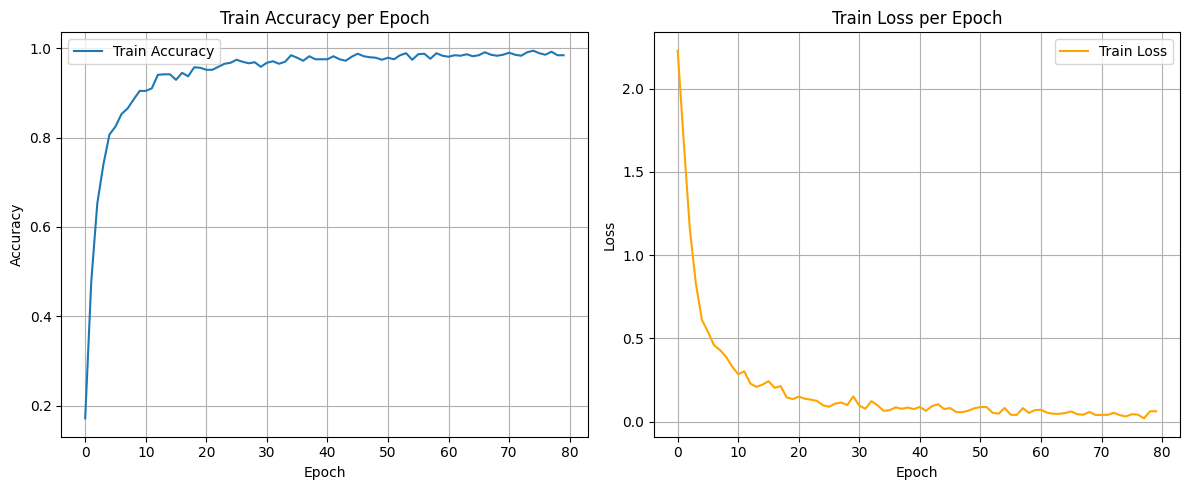

In [20]:
# Plot accuracy en loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy per Epoch')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss per Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Visualiseren model architectuur

In [ ]:
import visualkeras

model = load_model("models/final_model_full_train.keras")


In [43]:
img = visualkeras.layered_view(
    model,
    legend=True,
    draw_volume=True,
    spacing=10,
    max_z=8,
    scale_xy=1,
    scale_z=1
)

# Vergroot het beeld voor betere scherpte
img = img.resize((img.width * 4, img.height * 4), Image.LANCZOS)
img.save("model_visual_highres.png")

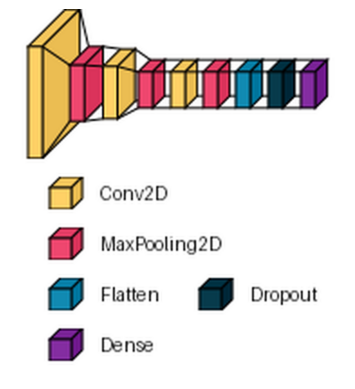

In [46]:
import matplotlib.pyplot as plt

img = plt.imread("model_visual_highres.png")

plt.imshow(img)
plt.axis('off')  # Verberg de assen


plt.show()